# Assignment 7: Linear Model Selection and Regularization

Dataset(s) needed:
Kaggle House Prices (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

Libraries needed:
glmnet

Convert building class code (MSSubClass) to a factor.
For numeric NA values, impute by taking each column’s mean.
For non-numeric, apply an appropriate technique.



In [88]:
library("caret")
library("glmnet")
library("mice")
library("dplyr")
library("ggplot2")

houses <- read.csv("https://library.startlearninglabs.uw.edu/ML210/train.csv")
# Convert 'MSSubClass' to factor
houses$MSSubClass <- as.factor(houses$MSSubClass)

# There are two houses that appear to have erroneous price data
# They are both large houses, overall quality 10, but sold for less than 200K
# They end up being severely underpredicted in terms of value, 
# so they will be removed up front
houses <- houses[-c(524,1299), ]

str(houses)

# Show # of NA's:
na.cols <- sapply(houses, function(x) sum(is.na(x)))
cat('Percent missing values by feature:\n')
na.perc <- na.cols[na.cols > 0]/nrow(houses) * 100
print(na.perc)

'data.frame':	1458 obs. of  81 variables:
 $ Id           : int  1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass   : Factor w/ 15 levels "20","30","40",..: 6 1 6 7 6 5 1 6 5 15 ...
 $ MSZoning     : Factor w/ 5 levels "C (all)","FV",..: 4 4 4 4 4 4 4 4 5 4 ...
 $ LotFrontage  : int  65 80 68 60 84 85 75 NA 51 50 ...
 $ LotArea      : int  8450 9600 11250 9550 14260 14115 10084 10382 6120 7420 ...
 $ Street       : Factor w/ 2 levels "Grvl","Pave": 2 2 2 2 2 2 2 2 2 2 ...
 $ Alley        : Factor w/ 2 levels "Grvl","Pave": NA NA NA NA NA NA NA NA NA NA ...
 $ LotShape     : Factor w/ 4 levels "IR1","IR2","IR3",..: 4 4 1 1 1 1 4 1 4 4 ...
 $ LandContour  : Factor w/ 4 levels "Bnk","HLS","Low",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Utilities    : Factor w/ 2 levels "AllPub","NoSeWa": 1 1 1 1 1 1 1 1 1 1 ...
 $ LotConfig    : Factor w/ 5 levels "Corner","CulDSac",..: 5 3 5 1 3 5 5 1 5 1 ...
 $ LandSlope    : Factor w/ 3 levels "Gtl","Mod","Sev": 1 1 1 1 1 1 1 1 1 1 ...
 $ Neighborhood : Factor w/ 25 levels

In [89]:
# Impute mean value for numeric columns
numeric.features <- sapply(houses, function(x) is.numeric(x))    
numeric.na <- names(houses[, na.cols & numeric.features])   
cat('Numeric columns with missing values:\n',numeric.na,'\n')
cat('\nMean values:\n')
sapply(houses[, numeric.na], function(x) mean(x, na.rm = TRUE))
houses[, numeric.na] <- sapply(houses[, numeric.na], 
        function(x) replace(x, is.na(x), mean(x, na.rm = TRUE)))

Numeric columns with missing values:
 LotFrontage MasVnrArea GarageYrBlt 

Mean values:


LotFrontage  MasVnrArea GarageYrBlt 
   69.79733   102.75379  1978.46405

In [90]:
# Look at categorical features with large % of missing values
high.missing <- names(which(na.perc > 20))
for (ind in seq(length(high.missing))) {
    # Add 'None', assuming missing values are for homes without this feature
    levels(houses[[high.missing[ind]]]) <- c(levels(houses[[high.missing[ind]]]),'None')
    houses[[high.missing[ind]]][is.na(houses[[high.missing[ind]]])] <- 'None'
    cat(high.missing[ind],'levels (after imputation) :\n')
    print(levels(houses[[high.missing[ind]]]))
}

Alley levels (after imputation) :
[1] "Grvl" "Pave" "None"
FireplaceQu levels (after imputation) :
[1] "Ex"   "Fa"   "Gd"   "Po"   "TA"   "None"
PoolQC levels (after imputation) :
[1] "Ex"   "Fa"   "Gd"   "None"
Fence levels (after imputation) :
[1] "GdPrv" "GdWo"  "MnPrv" "MnWw"  "None" 
MiscFeature levels (after imputation) :
[1] "Gar2" "Othr" "Shed" "TenC" "None"


In [91]:
# Show # of NA's remaining:
na.cols <- sapply(houses, function(x) sum(is.na(x)))
cat('Percent missing values by feature:\n')
na.perc <- na.cols[na.cols > 0]/nrow(houses) * 100
print(na.perc)

Percent missing values by feature:
  MasVnrType     BsmtQual     BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 
  0.54869684   2.53772291   2.53772291   2.60631001   2.53772291   2.60631001 
  Electrical   GarageType GarageFinish   GarageQual   GarageCond 
  0.06858711   5.55555556   5.55555556   5.55555556   5.55555556 


In [92]:
# Since missing percentages for garage and basement features are equal,
# assume NA values correspond to homes without garages or basements, add
# 'None' level to factors to account for this

garage.missing <- names(na.perc)[grep('Garage',names(na.perc))]
for (ind in seq(length(garage.missing))) {
    levels(houses[[garage.missing[ind]]]) <- c(levels(houses[[garage.missing[ind]]]),'None')
    houses[[garage.missing[ind]]][is.na(houses[[garage.missing[ind]]])] <- 'None'
    cat(garage.missing[ind],'levels (after imputation) :\n')
    print(levels(houses[[garage.missing[ind]]]))
}
bsmt.missing <- names(na.perc)[grep('Bsmt',names(na.perc))]
for (ind in seq(length(bsmt.missing))) {
    levels(houses[[bsmt.missing[ind]]]) <- c(levels(houses[[bsmt.missing[ind]]]),'None')
    houses[[bsmt.missing[ind]]][is.na(houses[[bsmt.missing[ind]]])] <- 'None'
    cat(bsmt.missing[ind],'levels (after imputation) :\n')
    print(levels(houses[[bsmt.missing[ind]]]))
}

GarageType levels (after imputation) :
[1] "2Types"  "Attchd"  "Basment" "BuiltIn" "CarPort" "Detchd"  "None"   
GarageFinish levels (after imputation) :
[1] "Fin"  "RFn"  "Unf"  "None"
GarageQual levels (after imputation) :
[1] "Ex"   "Fa"   "Gd"   "Po"   "TA"   "None"
GarageCond levels (after imputation) :
[1] "Ex"   "Fa"   "Gd"   "Po"   "TA"   "None"
BsmtQual levels (after imputation) :
[1] "Ex"   "Fa"   "Gd"   "TA"   "None"
BsmtCond levels (after imputation) :
[1] "Fa"   "Gd"   "Po"   "TA"   "None"
BsmtExposure levels (after imputation) :
[1] "Av"   "Gd"   "Mn"   "No"   "None"
BsmtFinType1 levels (after imputation) :
[1] "ALQ"  "BLQ"  "GLQ"  "LwQ"  "Rec"  "Unf"  "None"
BsmtFinType2 levels (after imputation) :
[1] "ALQ"  "BLQ"  "GLQ"  "LwQ"  "Rec"  "Unf"  "None"


In [93]:
# Show # of NA's remaining:
na.cols <- sapply(houses, function(x) sum(is.na(x)))
cat('Percent missing values by feature:\n')
na.perc <- na.cols[na.cols > 0]/nrow(houses) * 100
print(na.perc)

Percent missing values by feature:
MasVnrType Electrical 
0.54869684 0.06858711 


In [94]:
# Use MICE to impute values for remaining categorical columns
temp.houses <- mice(houses %>% select(-c(Id,SalePrice)), method = 'polyreg', m = 5, maxit = 1)


 iter imp variable
  1   1  MasVnrType  Electrical
  1   2  MasVnrType  Electrical
  1   3  MasVnrType  Electrical
  1   4  MasVnrType  Electrical
  1   5  MasVnrType  Electrical


In [95]:
# Expand and merge Id and SalePrice columns back
temp.houses <- complete(temp.houses,1)
houses <- cbind(Id = houses$Id, temp.houses, SalePrice = houses$SalePrice)
head(houses)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,None,Reg,Lvl,AllPub,⋯,0,None,None,None,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,None,Reg,Lvl,AllPub,⋯,0,None,None,None,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,None,IR1,Lvl,AllPub,⋯,0,None,None,None,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,None,IR1,Lvl,AllPub,⋯,0,None,None,None,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,None,IR1,Lvl,AllPub,⋯,0,None,None,None,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,None,IR1,Lvl,AllPub,⋯,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000


Partition the data into training and test sets.

In [96]:
set.seed(0327)
trainFrac <- 0.70
trainSize = round(nrow(houses)*trainFrac)
trainInd <- sample(seq(nrow(houses)),trainSize)
train <- houses[trainInd, ]
test <- houses[-trainInd, ]

## Lasso Regression

Fit lasso regression to training data, while choosing optimum value of regularization factor hyperparameter λ

Optimal value of lambda = 574.7978 
Log lambda value = 6.354018

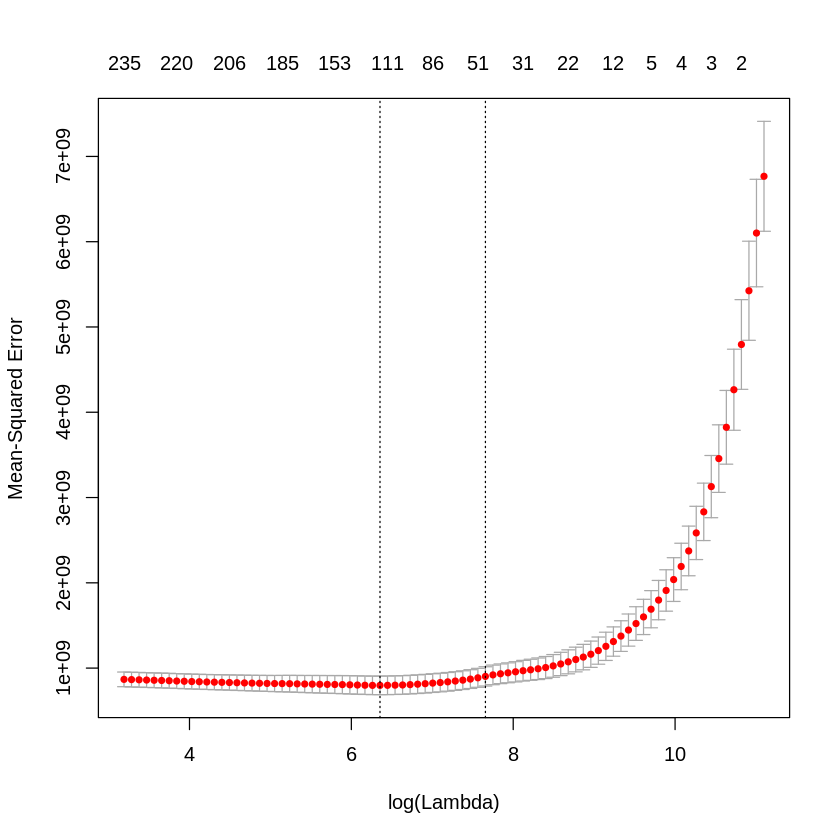

In [97]:
# Create model matrix with dummy variables
x <- model.matrix(SalePrice ~ ., data = train %>% select(-Id))
y <- train$SalePrice
glm.lasso <- cv.glmnet(x,y,family = 'gaussian',alpha = 1)
plot(glm.lasso)
cat('Optimal value of lambda =',glm.lasso$lambda.min,'\n')
cat('Log lambda value =',log(glm.lasso$lambda.min))

How many columns has the model chosen?

In [98]:
# First find coefficients for min lambda
lasso.coef <- coef(glm.lasso, s = "lambda.min")
idx <- which(lasso.coef != 0)
cat('LASSO regularization chose',length(idx),'columns out of',ncol(x),'\n')

LASSO regularization chose 115 columns out of 273 


Using t value, what are the most important variables according to your model?
To what extent does this match your intuition?

First, we need to restandardize the coefficients so that we can rank them by magnitude. We can do this by multiplying the coefficients by the standard deviation of the associated feature.

In [99]:
feature.sd <- apply(x,2,sd)
feature.coeffs <- as.matrix(coef(glm.lasso, s = "lambda.min"))
std_coefs <- feature.coeffs[-1, 1] * feature.sd
std_coefs <- std_coefs[which(std_coefs != 0)]
ordered.coef <- data.frame(StandardizedCoef = std_coefs[order(std_coefs, decreasing = TRUE)])

The most important variables for $increasing$ home price are

In [100]:
head(ordered.coef, n = 10)

,StandardizedCoef
GrLivArea,29981.791
OverallQual,12266.717
YearBuilt,8059.007
BsmtFinSF1,8008.336
TotalBsmtSF,7852.136
SaleType7,7542.422
MasVnrArea,6324.704
OverallCond,5402.379
BsmtExposure2,5372.447
RoofMatl8,5069.451


The most important variables for $decreasing$ home price are

In [101]:
tail(ordered.coef, n = 10)

,StandardizedCoef
BedroomAbvGr,-2757.739
PoolQC3,-3037.271
PoolQC2,-3449.943
KitchenAbvGr,-3823.004
ExterQual4,-3898.458
BsmtQual4,-4948.505
KitchenQual4,-5178.303
BsmtQual3,-6167.689
KitchenQual3,-6566.285
PoolQC4,-8304.700


These results mostly match my intuition. The most important features related to higher home prices are things like:
* Total square footage (main floors and basement)
* Overall condition/quality
* Year built
* Neighborhood

The most important features related to lower home prices are those related to condition and quality (kitchen, basement, overall), and a certain building type.

For comparison purposes, we should calculate the MSE and RMSE for the LASSO model.

In [102]:
# Find the training MSE associated with lambda min
train.mse <- glm.lasso$cvm[glm.lasso$lambda == glm.lasso$lambda.min]
cat('LASSO training MSE for min lambda =',train.mse,'\n')
cat('LASSO training RMSE for min lambda (in dollars) = ',sqrt(train.mse),'\n\n')

# Find test MSE
x.test <- model.matrix(SalePrice ~ ., data = test %>% select(-Id))
predict.lasso <- predict(glm.lasso, newx = x.test, s = glm.lasso$lambda.min)
test.mse <- sum((test$SalePrice - predict.lasso)^2)/nrow(test)
cat('LASSO test MSE for min lambda =',test.mse,'\n')
cat('LASSO test RMSE for min lambda (in dollars) = ',sqrt(test.mse),'\n')

LASSO training MSE for min lambda = 797190490 
LASSO training RMSE for min lambda (in dollars) =  28234.56 

LASSO test MSE for min lambda = 602293635 
LASSO test RMSE for min lambda (in dollars) =  24541.67 


We should also check to see if we need to transform the response variable before proceeding

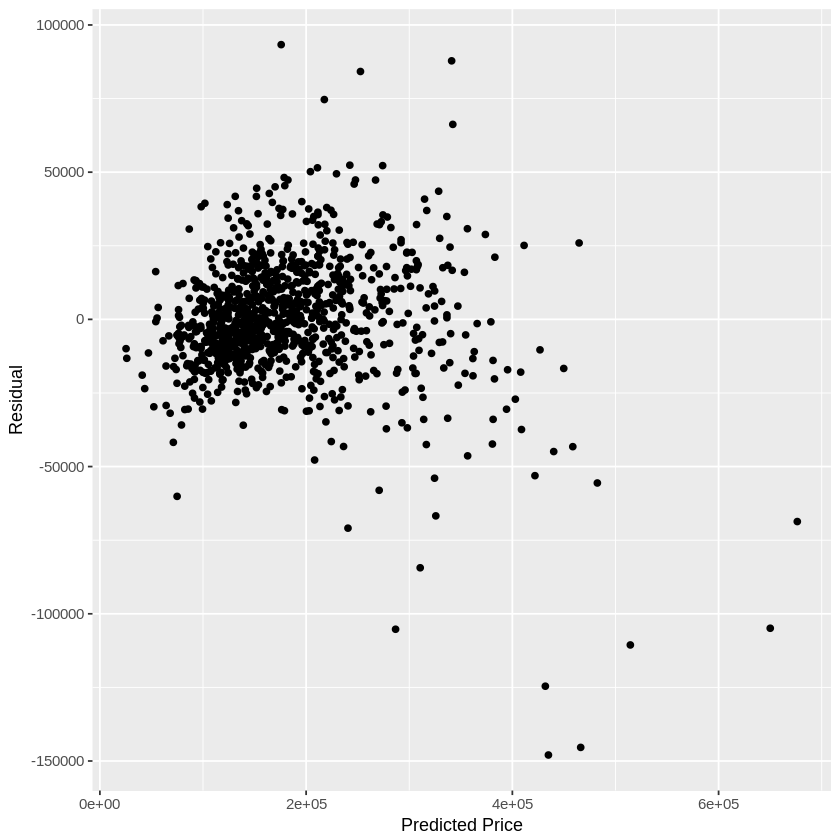

In [103]:
train.Predict <- predict(glm.lasso, newx = x, s = glm.lasso$lambda.min)
train.Resid <- train.Predict - y
trainDF <- data.frame("predictPrice" = as.vector(train.Predict), 
                      "resid" = as.vector(train.Resid))
ggplot(trainDF, aes(x = predictPrice, y = resid)) + geom_point() + 
xlab('Predicted Price') + ylab('Residual')

There is definitely some heteroscedasticity in the model, so let's log transform the price and create a new model.

In [104]:
# Add log price to train and test data
train$logPrice <- log(train$SalePrice)
test$logPrice <- log(test$SalePrice)

# Create model matrix with dummy variables
xLog <- model.matrix(logPrice ~ ., data = train %>% select(-c(Id,SalePrice)))
yLog <- train$logPrice
glm.lasso <- cv.glmnet(xLog,yLog,family = 'gaussian',alpha = 1)

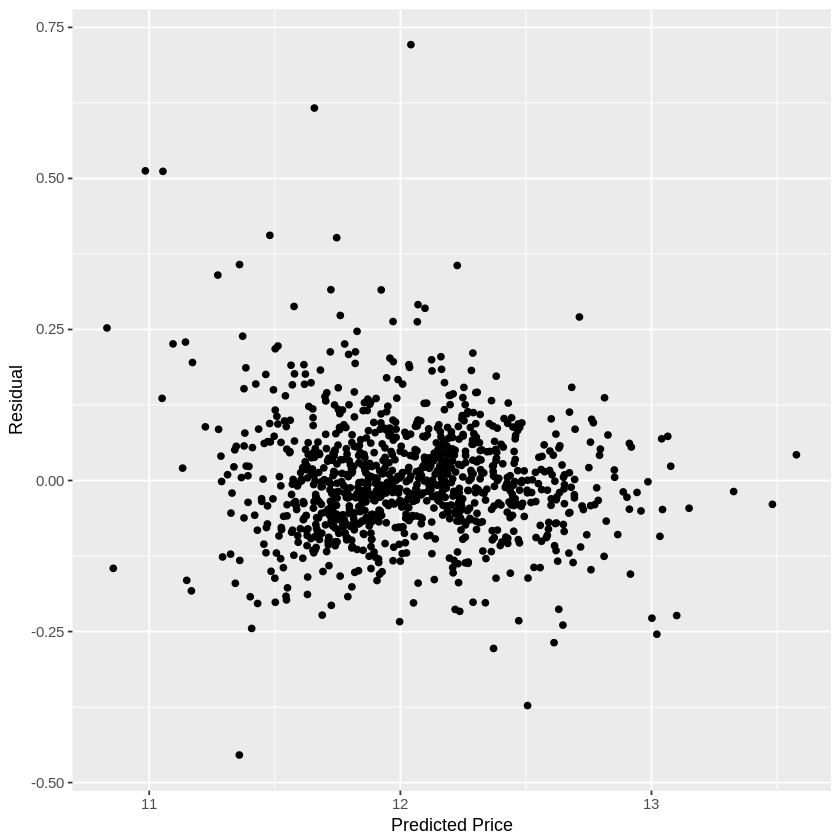

In [106]:
train.Predict <- predict(glm.lasso, newx = xLog, s = glm.lasso$lambda.min)
train.Resid <- train.Predict - yLog
trainDF <- data.frame("predictPrice" = as.vector(train.Predict), 
                      "resid" = as.vector(train.Resid))
ggplot(trainDF, aes(x = predictPrice, y = resid)) + geom_point() + 
xlab('Predicted Price') + ylab('Residual')

This looks much better, let's recompute the test MSE to compare to Ridge and Elastic Net.

In [107]:
# Find the new training MSE associated with lambda min
train.mse <- glm.lasso$cvm[glm.lasso$lambda == glm.lasso$lambda.min]
cat('LASSO training MSE for min lambda =',train.mse,'\n')
cat('LASSO training RMSE for min lambda (in log(dollars)) = ',sqrt(train.mse),'\n\n')

# Find new test MSE
x.test <- model.matrix(logPrice ~ ., data = test %>% select(-c(Id,SalePrice)))
predict.lasso <- exp(predict(glm.lasso, newx = x.test, s = glm.lasso$lambda.min))
test.mse <- sum((test$SalePrice - predict.lasso)^2)/nrow(test)
cat('LASSO test MSE for min lambda =',test.mse,'\n')
cat('LASSO test RMSE for min lambda (in dollars) = ',sqrt(test.mse),'\n')

LASSO training MSE for min lambda = 0.01341407 
LASSO training RMSE for min lambda (in log(dollars)) =  0.1158191 

LASSO test MSE for min lambda = 390074594 
LASSO test RMSE for min lambda (in dollars) =  19750.31 


Note that the test RMSE dropped by nearly $5,000 when using the log price as the response.

## Ridge Regression

Perform ridge regression, while choosing optimum value of hyperparameter λ.

Optimal value of lambda = 0.1495305 
Log lambda value = -1.900255

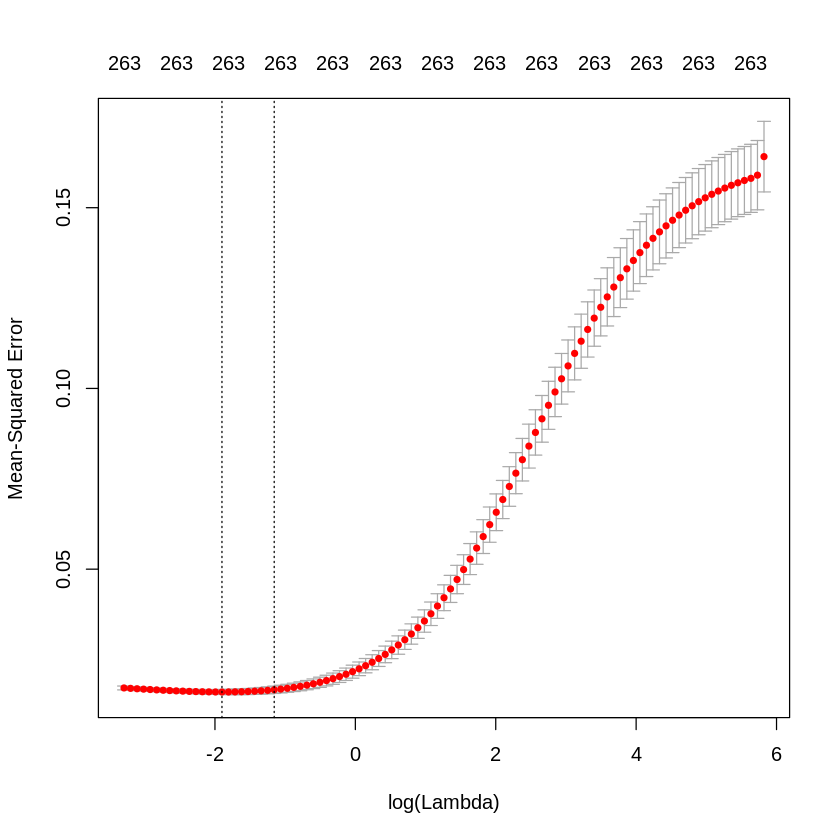

In [108]:
glm.ridge <- cv.glmnet(xLog,yLog,family = 'gaussian',alpha = 0)
plot(glm.ridge)
cat('Optimal value of lambda =',glm.ridge$lambda.min,'\n')
cat('Log lambda value =',log(glm.ridge$lambda.min))

What is your mean squared error (MSE)?

In [109]:
# Find the training MSE associated with lambda min
train.mse <- glm.ridge$cvm[glm.ridge$lambda == glm.ridge$lambda.min]
cat('Ridge training MSE for min lambda =',train.mse,'\n')
cat('Ridge training RMSE for min lambda (in log(dollars)) = ',sqrt(train.mse),'\n\n')

# Find test MSE
predict.ridge <- exp(predict(glm.ridge, newx = x.test, s = glm.ridge$lambda.min))
test.mse <- sum((test$SalePrice - predict.ridge)^2)/nrow(test)
cat('Ridge test MSE for min lambda =',test.mse,'\n')
cat('Ridge test RMSE for min lambda (in dollars) = ',sqrt(test.mse),'\n')

Ridge training MSE for min lambda = 0.01601597 
Ridge training RMSE for min lambda (in log(dollars)) =  0.1265542 

Ridge test MSE for min lambda = 434260076 
Ridge test RMSE for min lambda (in dollars) =  20838.91 


Note that the MSE for the ridge regression model is slightly higher than that of the LASSO model.

## Elastic Net Regression

Perform elastic net regression. Use the caret library's feature for selecting the best value of α.


In [110]:
# Set up controls
tc <- trainControl(method = 'cv', number = 10, search = 'grid')
xDV <- dummyVars(~ ., data = train %>% select(-c(Id,SalePrice,logPrice)), fullRank = TRUE)
xTrain <- data.frame(predict(xDV, newdata = train))
glm.elastic <- train(xTrain, yLog, 
                     method = 'glmnet', metric = 'RMSE', trControl = tc, tuneLength = 5)
print(glm.elastic)

Warning message:
“contrasts dropped from factor MSSubClass”Warning message:
“contrasts dropped from factor MSZoning”Warning message:
“contrasts dropped from factor Street”Warning message:
“contrasts dropped from factor Alley”Warning message:
“contrasts dropped from factor LotShape”Warning message:
“contrasts dropped from factor LandContour”Warning message:
“contrasts dropped from factor Utilities”Warning message:
“contrasts dropped from factor LotConfig”Warning message:
“contrasts dropped from factor LandSlope”Warning message:
“contrasts dropped from factor Neighborhood”Warning message:
“contrasts dropped from factor Condition1”Warning message:
“contrasts dropped from factor Condition2”Warning message:
“contrasts dropped from factor BldgType”Warning message:
“contrasts dropped from factor HouseStyle”Warning message:
“contrasts dropped from factor RoofStyle”Warning message:
“contrasts dropped from factor RoofMatl”Warning message:
“contrasts dropped from factor Exterior1st”Warning messag

glmnet 

1021 samples
 272 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 920, 919, 919, 918, 917, 920, ... 
Resampling results across tuning parameters:

  alpha  lambda        RMSE       Rsquared   MAE       
  0.100  0.0003133011  0.1392851  0.8892477  0.09439276
  0.100  0.0014542149  0.1336955  0.8974846  0.09166657
  0.100  0.0067498675  0.1242923  0.9103373  0.08701160
  0.100  0.0313301098  0.1157597  0.9211903  0.08241340
  0.100  0.1454214878  0.1302360  0.9078628  0.09140889
  0.325  0.0003133011  0.1362548  0.8937281  0.09299029
  0.325  0.0014542149  0.1275963  0.9060767  0.08863409
  0.325  0.0067498675  0.1173603  0.9192524  0.08335172
  0.325  0.0313301098  0.1213631  0.9142450  0.08643532
  0.325  0.1454214878  0.1628939  0.8810671  0.11558987
  0.550  0.0003133011  0.1340351  0.8969927  0.09182719
  0.550  0.0014542149  0.1238909  0.9109682  0.08685078
  0.550  0.0067498675  0.1155746  0.9213104  0.08225580
  0.550  0.0313

In [111]:
# Look at variable importance
varImp(glm.elastic, scale = FALSE)

glmnet variable importance

  only 20 most important variables shown (out of 272)

                     Overall
Functional.Sev       0.23647
Street.Pave          0.12522
Exterior1st.BrkComm  0.12197
SaleType.New         0.11641
Heating.Grav         0.10062
Neighborhood.Crawfor 0.09885
Neighborhood.StoneBr 0.09363
Functional.Maj2      0.08642
Exterior1st.BrkFace  0.06523
Neighborhood.MeadowV 0.06267
Neighborhood.Somerst 0.06247
OverallQual          0.06011
RoofMatl.Membran     0.05896
MSSubClass.160       0.05837
Functional.Mod       0.05421
SaleCondition.Normal 0.05382
CentralAir.Y         0.05369
RoofMatl.WdShngl     0.05188
BsmtExposure.Gd      0.05146
Neighborhood.NridgHt 0.04930

In [114]:
# Find test MSE
xDV <- dummyVars(~ ., data = test %>% select(-c(Id,SalePrice,logPrice)), fullRank = TRUE)
xTest <- data.frame(predict(xDV, newdata = test))
predict.elastic <- exp(predict(glm.elastic, newdata = xTest))
test.mse <- sum((test$SalePrice - predict.elastic)^2)/nrow(test)
cat('Elastic net test MSE for min lambda =',test.mse,'\n')
cat('Elastic net test RMSE for min lambda (in dollars) = ',sqrt(test.mse),'\n')

Warning message:
“contrasts dropped from factor MSSubClass”Warning message:
“contrasts dropped from factor MSZoning”Warning message:
“contrasts dropped from factor Street”Warning message:
“contrasts dropped from factor Alley”Warning message:
“contrasts dropped from factor LotShape”Warning message:
“contrasts dropped from factor LandContour”Warning message:
“contrasts dropped from factor Utilities”Warning message:
“contrasts dropped from factor LotConfig”Warning message:
“contrasts dropped from factor LandSlope”Warning message:
“contrasts dropped from factor Neighborhood”Warning message:
“contrasts dropped from factor Condition1”Warning message:
“contrasts dropped from factor Condition2”Warning message:
“contrasts dropped from factor BldgType”Warning message:
“contrasts dropped from factor HouseStyle”Warning message:
“contrasts dropped from factor RoofStyle”Warning message:
“contrasts dropped from factor RoofMatl”Warning message:
“contrasts dropped from factor Exterior1st”Warning messag

Elastic net test MSE for min lambda = 391918808 
Elastic net test RMSE for min lambda (in dollars) =  19796.94 


The RMSE for elastic net is approximately equal to the LASSO.